# Human Non-Speech Sound Classification
[INTRODUCTION TO THE PROBLEM HERE]

### Datasets
[DATASET DESCRIPTION HERE]


### Tasks
[TASK HERE]

### Integrants:
Name, Matricola, Email respectively
- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it
- Ivan Padezhki, XXXX, XXXX

## Dependencies

In [1]:
import os
import shutil
import urllib.request
import zipfile
import glob
import pandas as pd
import numpy as np
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import librosa
import librosa.display

## Download Dataset

In [2]:
def download_dataset(name):
    """
    Download the dataset into current working directory.
    
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    if not os.path.exists(name):
        os.mkdir(name)
        urllib.request.urlretrieve(f'https://github.com/karoldvl/{name}/archive/master.zip', f'{name}/{name}.zip')

        with zipfile.ZipFile(f'{name}/{name}.zip') as package:
            package.extractall(f'{name}/')

        os.unlink(f'{name}/{name}.zip')        

        for src in glob.glob(f'{name}/{name}-master/*'):
            shutil.move(src, '{0}/{1}'.format(name, os.path.basename(src)))

        shutil.rmtree(f'{name}/{name}-master')

download_dataset('ESC-50')

In [3]:
ls ESC-50

LICENSE           audio/            meta/             requirements.txt
README.md         esc50.gif         pytest.ini        tests/


## Sample Dataset: Non-Speech Human Sounds

In this project we are going to fucus at identifying non-speech human sounds. Such as: `crying_baby`, `sneezing`, `clapping`, etc. So we are going to filter these categories from the main esc50 dataset.

In [4]:
esc50 = pd.read_csv("ESC-50/meta/esc50.csv")

human_cats = ['crying_baby', 'sneezing', 'clapping', 
              'breathing', 'coughing', 'footsteps', 
              'laughing', 'brushing_teeth', 'snoring', 
              'drinking_sipping']

esc50_human = esc50[esc50["category"].isin(human_cats)]

In [5]:
esc50_human.head()

,filename,fold,target,category,esc10,src_file,take
11,1-104089-A-22.wav,1,22,clapping,False,104089,A
12,1-104089-B-22.wav,1,22,clapping,False,104089,B
13,1-105224-A-22.wav,1,22,clapping,False,105224,A
15,1-110537-A-22.wav,1,22,clapping,False,110537,A
21,1-115920-A-22.wav,1,22,clapping,False,115920,A


## Exploratory Analysis

Let's start by looking at a single audio file of a baby crying.

In [127]:
def plot_example(filename):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    fig, axes = plt.subplots(3, 1)
    spf = wave.open("ESC-50/audio/" + filename, "r")
    category = esc50[esc50.filename == filename].category.values[0]

    # Extract Raw Audio from Wav File
    signal_raw = spf.readframes(-1)
    signal = np.frombuffer(signal_raw, "int16")

    axes[0].set_title(f"{category} - file: {filename}")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")
    axes[0].plot(np.arange(0, len(signal)) / RATE, signal)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    img = librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r', ax=axes[1])
    axes[1].set_title('Melspectrogram')
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Frequency(Hz)")
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    img = librosa.display.specshow(mfcc, x_axis='time',sr=RATE, cmap='RdBu_r', ax=axes[2])
    axes[2].set_title('MFCC')
    axes[2].set_ylabel("MFCC Coefficients")
    axes[2].set_xlabel("Time (s)")
    fig.tight_layout()
    plt.show()

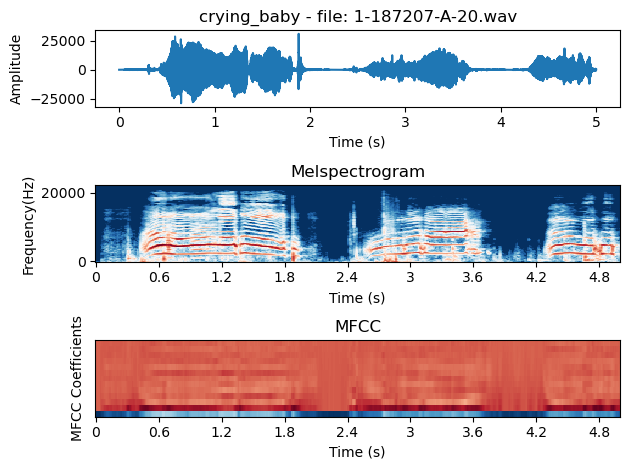

In [128]:
filename = "1-187207-A-20.wav"
plot_example(filename)
IPython.display.Audio("ESC-50/audio/" + filename)

Now, let's plot the amplitude and melspectrogram of one example per category.

In [134]:
def add_subplot_axes(ax, position):
    """
    Originally taken from https://nbviewer.org/github/karoldvl/paper-2015-esc-dataset/blob/
    master/Notebook/ESC-Dataset-for-Environmental-Sound-Classification.ipynb#Setup
    Additional modifications were applied to make it work with Python 3
    """
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]])

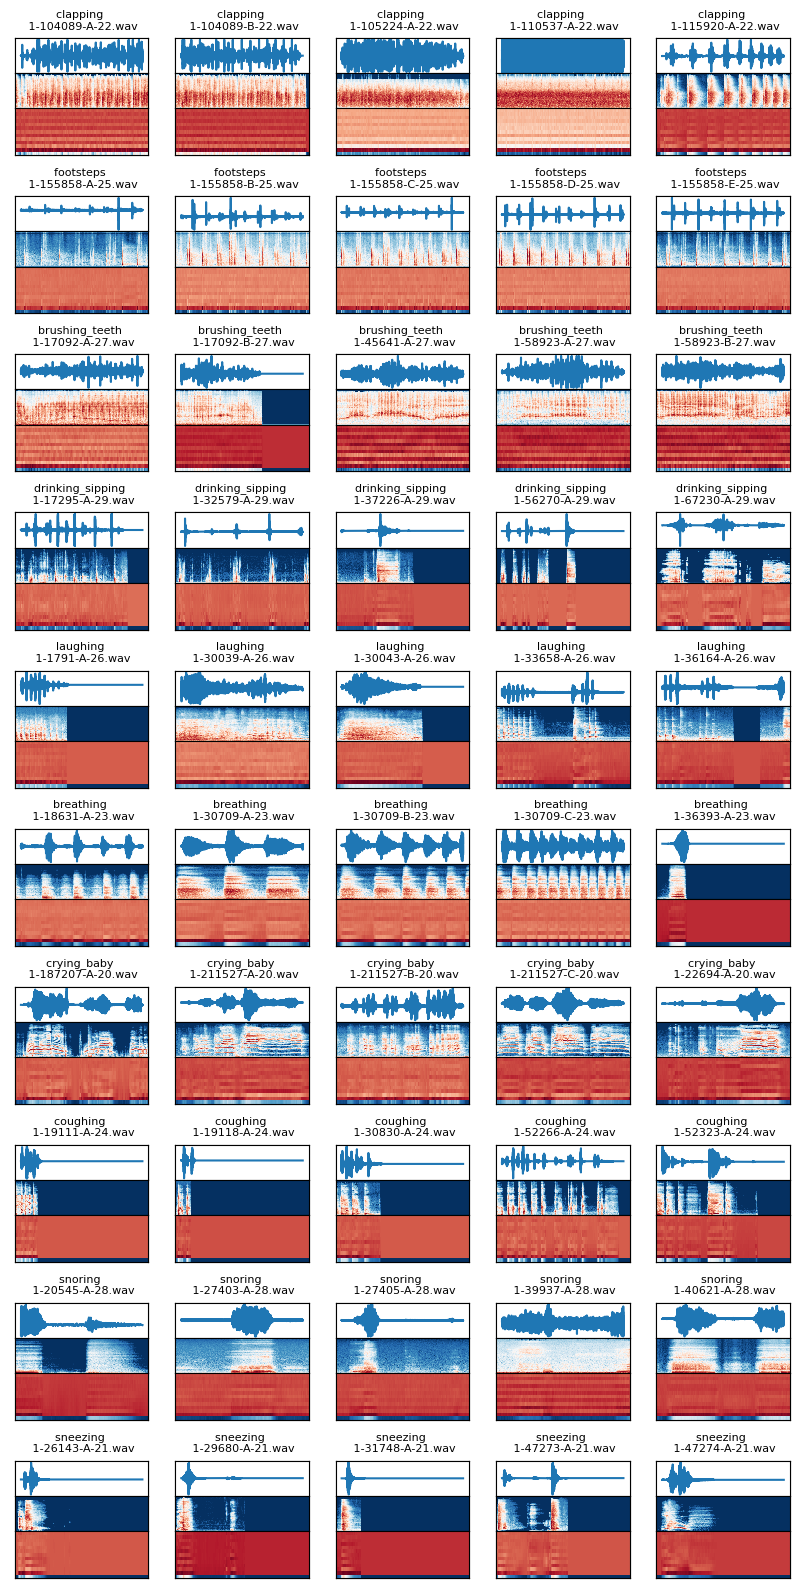

In [141]:
def plot_clip_overview(audio, category, filename ,ax):
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])     #[left, bottom, width, height]
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.4, 1.0, 0.3])
    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.4])
    
    # Extract Raw Audio from Wav File
    signal_raw = audio.readframes(-1)
    signal = np.frombuffer(signal_raw, "int16")
    ax_waveform.plot(np.arange(0, len(signal)) / float(RATE), signal)
    ax_waveform.get_xaxis().set_visible(False)
    ax_waveform.get_yaxis().set_visible(False)
    ax_waveform.set_title('{0} \n {1}'.format(category, filename), {'fontsize': 8}, y=1.03)

    # Compute Melspectrogram Features
    signal = (np.frombuffer(signal_raw, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float
    signal = librosa.feature.melspectrogram(y=signal, sr=RATE, hop_length=FRAME)
    signal = librosa.power_to_db(signal, ref=np.max)
    librosa.display.specshow(signal, x_axis='time', y_axis='linear', sr=RATE, cmap='RdBu_r',ax=ax_spectrogram)
    ax_spectrogram.get_xaxis().set_visible(False)
    ax_spectrogram.get_yaxis().set_visible(False)
    
    # Compute MFCC
    mfcc = librosa.feature.mfcc(S=signal, sr=RATE, n_mfcc=13)
    librosa.display.specshow(mfcc, x_axis='time', sr=RATE, cmap='RdBu_r', ax=ax_mfcc)
    ax_mfcc.get_xaxis().set_visible(False)
    ax_mfcc.get_yaxis().set_visible(False)
    
categories = esc50_human.category.unique()
categories_len = len(categories)
clips_shown = 5
f, axes = plt.subplots(categories_len, clips_shown,
                       figsize=(clips_shown * 2, categories_len * 2), 
                       sharex=True, 
                       sharey=True)
f.subplots_adjust(hspace = 0.35)

for i, c in enumerate(categories):
    for j in range(0, clips_shown):
        filename = esc50_human[esc50_human.category == c].filename.iloc[j]
        spf = wave.open("ESC-50/audio/" + filename, "r")
        plot_clip_overview(spf, c, filename, axes[i, j])